In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import scipy as sp

# Project's package
import sys
try:
    session_params is not None 
    sys.path.append("../auimpy")
    import prepair, air
except NameError:
    session_params = {
    'filters_applied': True, 
    'minimal_accuracy':60,
    'write_text': True,
    'save_figs': True,
    'input_method': 'mouse',
    'iters_num': 10000,
    }
    sys.path.append("../auimpy")
    import prepair, air

data = pd.read_csv('./input/exp1 - ia_middle_irrelevant.csv')
demog = pd.read_csv('./input/demog.csv')

In [2]:
# Unfortunatly we have demogrpahics only for 44 / 56 subjects.
print(demog['sex'].value_counts(normalize=True))
print(demog['age'].describe())
print(demog.shape[0])


Female    0.727273
Male      0.272727
Name: sex, dtype: float64
count    44.000000
mean     24.659091
std       4.778553
min      18.000000
25%      21.000000
50%      24.000000
75%      26.250000
max      39.000000
Name: age, dtype: float64
54


In [3]:
# PRE PROCESSING

# Handling headline rows 
data = data.loc[~(data['participant'].isna()) & ~(data['trials.thisN'].isna())]

# Non-Unique participant numbers have to be factorized (in conjunction with date)
data['participant'] = data['participant'].str.cat(
    data['date'].values, sep="_").astype('category').cat.codes.values

# Generate a numeric trial identifier
data.rename(columns={'trials.thisN': 'trial', 'mousePressedStart': 'keys_at_start'}, inplace=True) 

# RT in seconds >> RT in MS
data['rt'] = data['rt'].replace({-1: np.nan}) # Ilya coded missing responses as -1 RT
data['rt'] = data['rt'].multiply(1000).values

data.columns = [i.lower() for i in data.columns]

# Keep only the relevant columns for further processing of the data
data = data.drop(
    columns=[i for i in data.columns if i not in 
                          ['participant', 'date', 'rt', 'keys_at_start', 
                           'cuenumber', 'cond', 'distrtype', 'response',
                          'trial', 'date']])


# Remap the values to we could get a meaningful comparison with the 
# distractor (which is the finger's name)
data[['cuenumber', 'response', 'distrtype']] = (
    data[['cuenumber', 'response', 'distrtype']]).replace(
        {1: "Index", 2: "Ring"}).astype(str).apply(lambda s: s.str.title())

# Modify the condition labels. Middle is always irrelevant. Baseline (image) 
# is always Baseline (condition).
data['condition'] = data['distrtype'].copy(deep=False).replace(
    {"Middle" : "Irrelevant", "baseline": "Baseline"})

# Compare the distractor and cue and based on the comparison label the condition
data.loc[data['distrtype'].isin(['Ring', 'Index']), 'condition'] = np.where(
    data.loc[data['distrtype'].isin(['Ring', 'Index']), ["distrtype", "cuenumber"]].apply(
        lambda x: x[0] == x[1], axis=1), "Compatible", "Incompatible") 

# Label response accuracy
data['correct'] = np.where(data['cuenumber'] == data['response'], True, False)


In [4]:
prpr = prepair.PrepAIR(data=data, **session_params)

In [5]:
prpr.report_invalid_trials()

'Invalid trials included incorrect or omitted responses (8.39%), slow responses (>950ms, 0.98%) fast responses (<150ms, 3.5%), and trials in which participants did not press the keys down correctly in the beginning of the trial (6.85%). Finally, all data from 4 participants (<60% valid trials, 7.14% of 56) were removed. Total filtration amounted to 16.8%.'

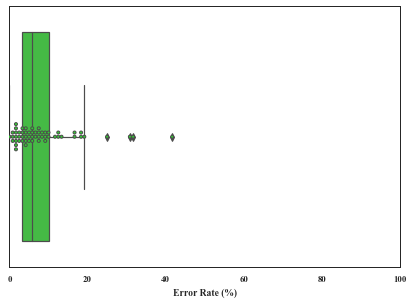

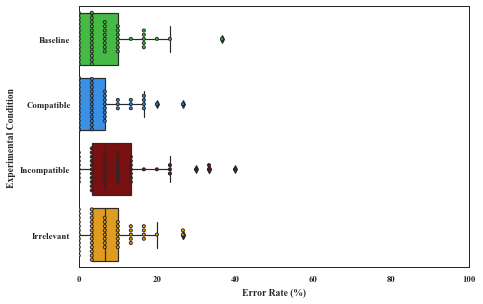

In [6]:
# Pre Filteration
prpr.plot_descriptives('er', by_condition=False, pre_filteration=True)
# Post Filteration
prpr.plot_descriptives('er', by_condition=True, pre_filteration=False)

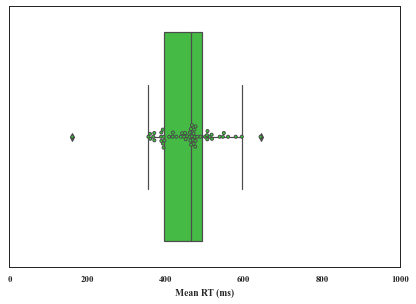

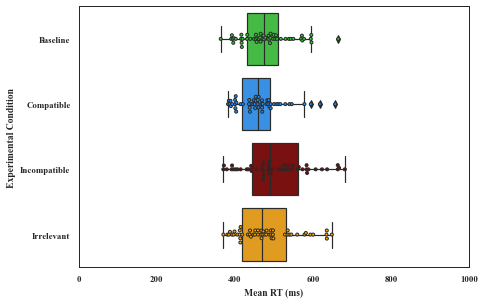

In [7]:
# Pre Filteration
prpr.plot_descriptives('rt', pre_filteration=True)
# Post Filteration
prpr.plot_descriptives('rt', by_condition=True, pre_filteration=False)

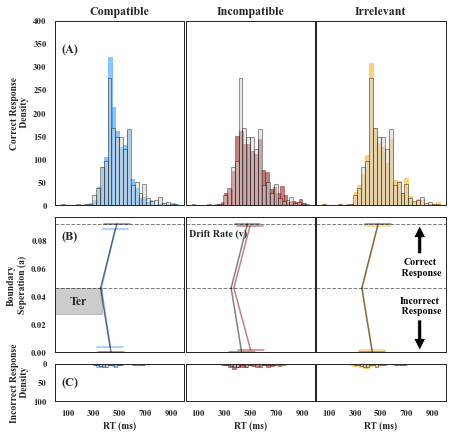

In [8]:
prpr.plot_diffusion()

In [9]:
*dfs, summary = prpr.get_finalized_data()
summary

,Mean Response Time,Error Rate,Drift Rate,Boundary Separation,Non-Decision Time
Condition (n = 52),,,,,
Baseline,480.8 (64.83),6.67 (7.35),0.32 (0.086),0.092 (0.016),351.83 (50.12)
Compatible,464.31 (60.47),5.38 (6.34),0.374 (0.1),0.084 (0.015),359.98 (46.68)
Incompatible,504.08 (82.58),9.87 (9.43),0.288 (0.103),0.088 (0.015),373.0 (71.57)
Irrelevant,480.83 (73.42),7.18 (6.78),0.321 (0.085),0.089 (0.018),356.31 (53.8)


In [10]:
rep = air.AIR(*dfs, **session_params)

C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "index". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "participant". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects\pandas2ri.py:67: UserWarning: Error while trying to convert the column "condition". Fall back to string conversion. The error is: Conversion 'py2ri' not defined for objects of type '<class 'pandas.core.series.Series'>'
  (name, str(e)))
C:\Users\Eitan Hemed\.conda\envs\pyr_env\lib\site-packages\rpy2\robjects

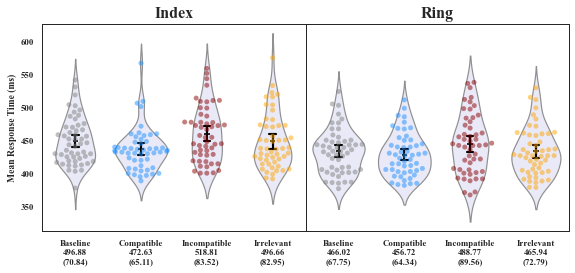

In [11]:
rep.plot_rt_by_fingers()

Repeated-Measures ANOVA showed a significant effect of experimental condition on Mean Response Time [F(1, 71) = 44.60, p < 0.001, Partial-η Squared = 0.467]
The Compatible condition Lower-tail t(51) = -4.26, p < 0.001, Mean Response Time Change -16.50ms, Cohen's d = -0.60 95%-CI [-0.89, -0.30], BF1:0 = 507.600
The Incompatible condition Upper-tail t(51) = 5.48, p < 0.001, Mean Response Time Change 23.27ms, Cohen's d = 0.77 95%-CI [0.45, 1.07], BF1:0 = 24707.550
The Irrelevant condition Two-tail t(51) = 0.01, p = 0.994, Mean Response Time Change 0.03ms, Cohen's d = 0.00 95%-CI [-0.27, 0.27], BF1:0 = 0.150


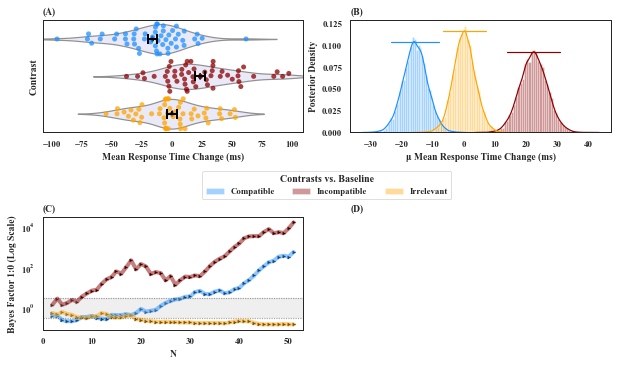

In [12]:
rep.report_results('rt')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Error Rate [F(2, 82) = 10.33, p < 0.001, Partial-η Squared = 0.168]
The Compatible condition Lower-tail t(51) = -1.85, p = 0.035, Error Rate Change -1.28%, Cohen's d = -0.26 95%-CI [-0.54, 0.02], BF1:0 = 1.420
The Incompatible condition Upper-tail t(51) = 2.95, p = 0.002, Error Rate Change 3.20%, Cohen's d = 0.41 95%-CI [0.13, 0.69], BF1:0 = 13.930
The Irrelevant condition Two-tail t(51) = 0.65, p = 0.516, Error Rate Change 0.51%, Cohen's d = 0.09 95%-CI [-0.18, 0.36], BF1:0 = 0.190


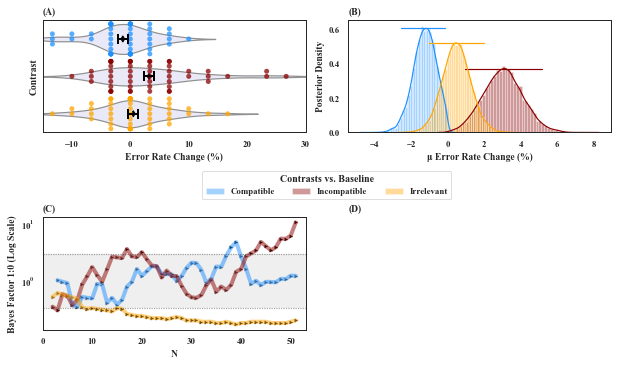

In [13]:
rep.report_results('er')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Drift Rate [F(2, 93) = 28.15, p < 0.001, Partial-η Squared = 0.356]
The Compatible condition Upper-tail t(51) = 4.93, p < 0.001, Drift Rate Change 0.0544v, Cohen's d = 0.69 95%-CI [0.39, 0.99], BF1:0 = 4192.410
The Incompatible condition Lower-tail t(51) = -3.00, p = 0.002, Drift Rate Change -0.0316v, Cohen's d = -0.42 95%-CI [-0.70, -0.13], BF1:0 = 15.690
The Irrelevant condition Two-tail t(51) = 0.11, p = 0.912, Drift Rate Change 0.0011v, Cohen's d = 0.02 95%-CI [-0.26, 0.29], BF1:0 = 0.150


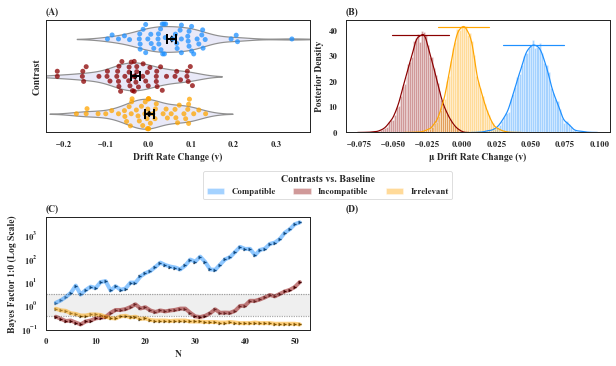

In [14]:
rep.report_results('drift_rate')

Repeated-Measures ANOVA showed an insignificant effect of experimental condition on Boundary Separation [F(2, 100) = 2.03, p = 0.137, Partial-η Squared = 0.038]
The Compatible condition Lower-tail t(51) = -3.27, p = 0.001, Boundary Separation Change -0.0077a, Cohen's d = -0.46 95%-CI [-0.74, -0.17], BF1:0 = 30.960
The Incompatible condition Upper-tail t(51) = -1.10, p = 0.863, Boundary Separation Change -0.0033a, Cohen's d = -0.15 95%-CI [-0.43, 0.12], BF1:0 = 0.080
The Irrelevant condition Two-tail t(51) = -1.28, p = 0.206, Boundary Separation Change -0.0030a, Cohen's d = -0.18 95%-CI [-0.45, 0.10], BF1:0 = 0.330


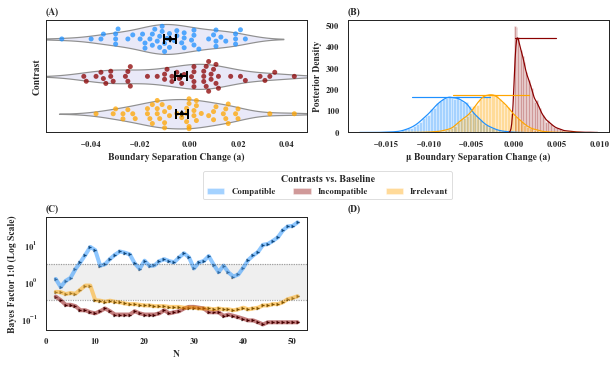

In [15]:
rep.report_results('boundary_separation')

Repeated-Measures ANOVA showed a significant effect of experimental condition on Non-Decision Time [F(2, 92) = 4.98, p = 0.011, Partial-η Squared = 0.089]
The Compatible condition Lower-tail t(51) = 1.71, p = 0.954, Non-Decision Time Change 0.0082s, Cohen's d = 0.24 95%-CI [-0.04, 0.51], BF1:0 = 0.060
The Incompatible condition Upper-tail t(51) = 3.23, p = 0.001, Non-Decision Time Change 0.0212s, Cohen's d = 0.45 95%-CI [0.17, 0.74], BF1:0 = 28.510
The Irrelevant condition Two-tail t(51) = 0.99, p = 0.328, Non-Decision Time Change 0.0045s, Cohen's d = 0.14 95%-CI [-0.14, 0.41], BF1:0 = 0.240


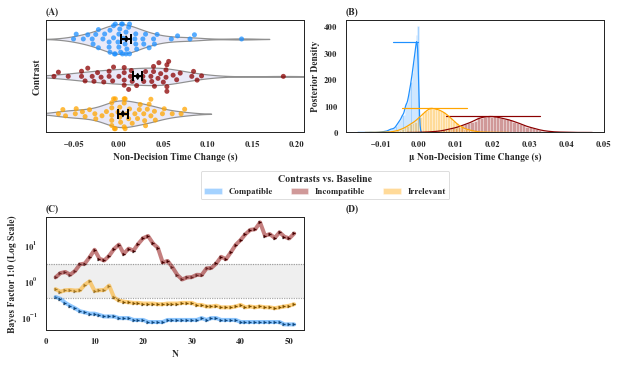

In [16]:
rep.report_results('non_decision_time')